In [19]:
import MySQLdb
import matplotlib
#matplotlib.use('Agg')
#matplotlib.use ('template')
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import pylab as pl
import sys, getopt
import time
import os
import numpy as np
import cPickle

In [20]:
estaciones = [106,91,94,93,99,140]
tipos = ['ni','ni','ni','ni','ni','ni']
tramos = [[106,91],[91,94],[94,93],[93,99],[99,140]]

localdate=time.localtime(time.time())
annoi=localdate[0] ; mesi=localdate[1] ; diai=localdate[2] ; horai=localdate[3] ; minui=localdate[4]
datel=datetime.datetime(int(annoi),int(mesi),int(diai),int(horai),int(minui))
#datel=datetime.datetime(2017,10,9,14,0)

# Cargar los pronosticos de nivel
f=open('/media/nicolas/Home/Jupyter/Esneider/modelo_crecidas/nivelesXreporte.bin','r')
niveles_mod = cPickle.load(f)
f.close()

mod_mat = np.zeros((len(niveles_mod),5))

for m in range(len(niveles_mod)):
    for col in range(5):
        mod_mat[m,col] = niveles_mod[m].split(',')[col]

106
79.4000244141


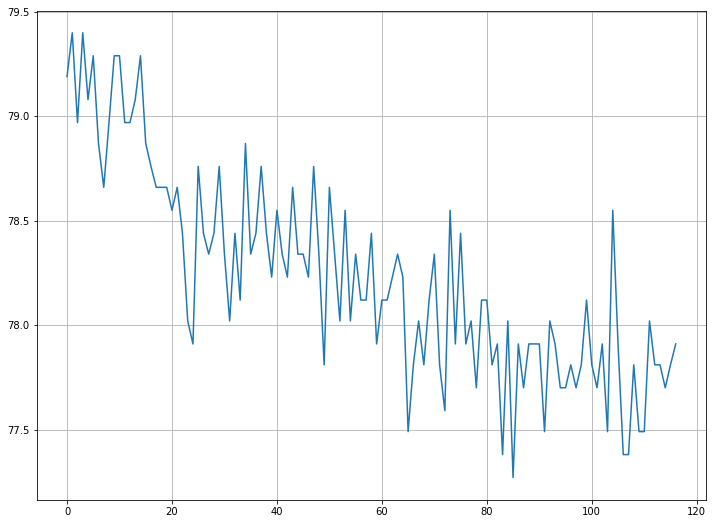

91
14.0


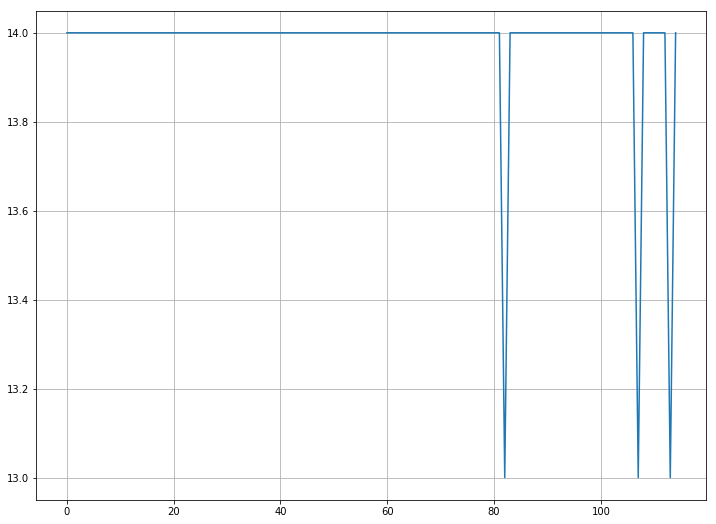

94
78.0


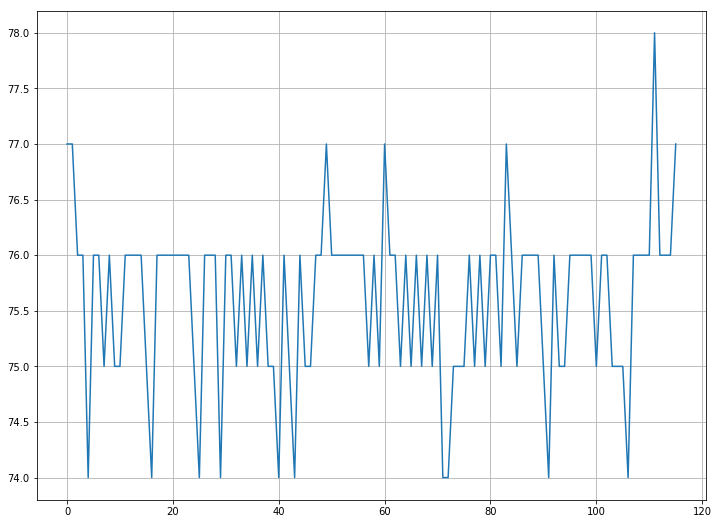

93
63.0


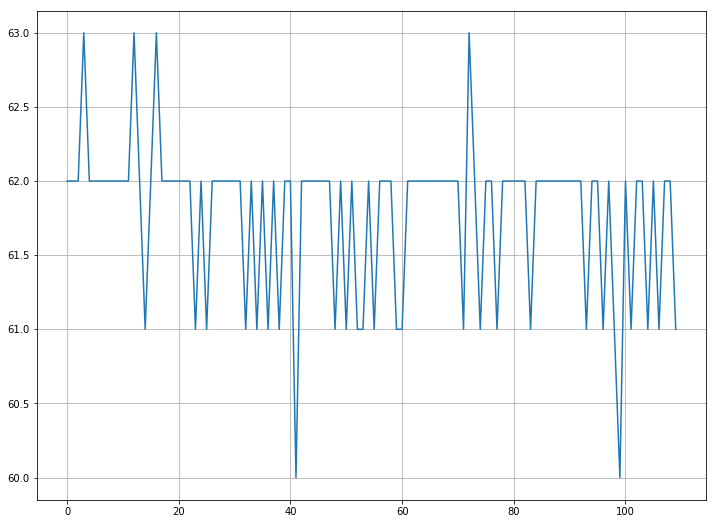

99
39.3199462891


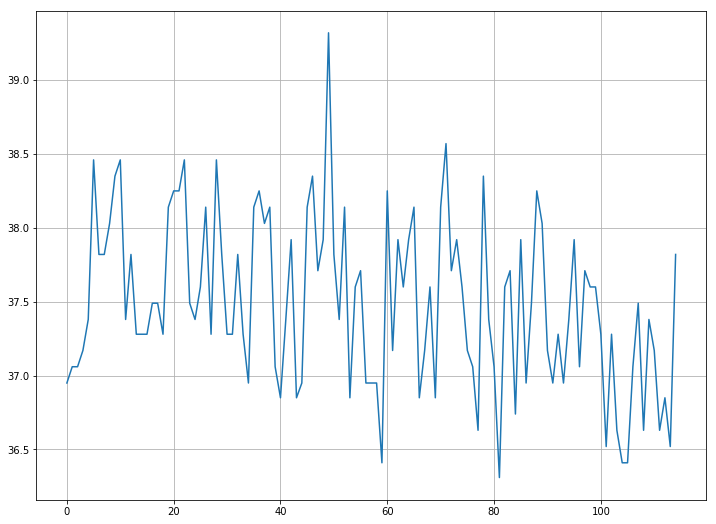

140
240.369995117


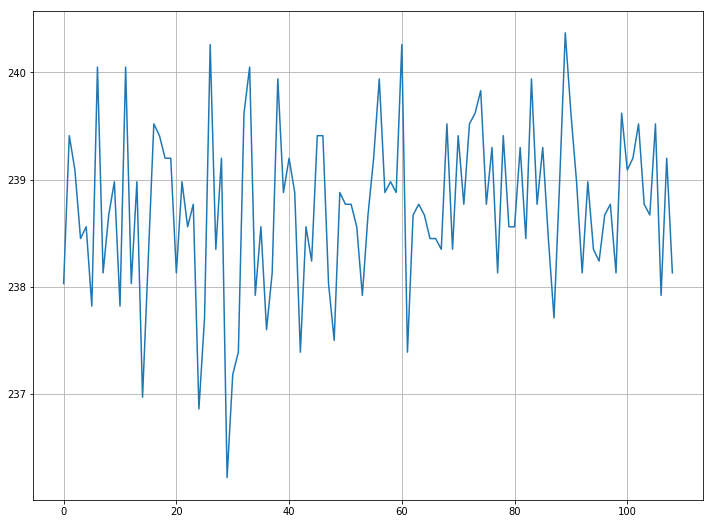

In [50]:
# Consulta de niveles maximos en las estaciones

tra_mat = np.zeros((len(estaciones),4))
tra_mat_ti = np.zeros((len(estaciones),4))

def consultaN(dt_fecha,n,red):

    date_fin=dt_fecha
    date_ini=dt_fecha-datetime.timedelta(minutes=120)
    datos_n = "SELECT fecha, DATE_FORMAT(fecha,'%Y-%m-%d'), hora, DATE_FORMAT(hora, '%H:%i:%s'), (" +str(Cod[0][2])+"-"+red+"), calidad FROM datos WHERE cliente = "+str(n)+" and (((fecha>'"+str(date_ini.year)+"-"+str(date_ini.month)+"-"+str(date_ini.day)+"') or (fecha='"+str(date_ini.year)+"-"+str(date_ini.month)+"-"+str(date_ini.day)+"' and hora>='"+str(date_ini.hour)+":"+str(date_ini.minute)+":00')) and ((fecha<'"+str(date_fin.year)+"-"+str(date_fin.month)+"-"+str(date_fin.day)+"') or (fecha='"+str(date_fin.year)+"-"+str(date_fin.month)+"-"+str(date_fin.day)+"' and hora<='"+str(date_fin.hour)+":"+str(date_fin.minute)+":00')))"
    db = MySQLdb.connect(host, user,passw,bd_nombre)
    db_cursor = db.cursor()
    db_cursor.execute(datos_n)
    data = db_cursor.fetchall()
    N=[] ; fec=[]

    for dato in data:
        if (dato[5] == 1) and (dato[4] < 1000):
            N.append(dato[4])
            fec.append(dato)

    return N,fec

max_BD = [] ; date_BD = []
estado_creciente = []

for k in range(len(estaciones)):
    
    # open database connection
    host      ='192.168.1.74'
    user      ='usrCalidad'
    passw     ='aF05wnXC;'
    bd_nombre ='siata'

    Estaciones="SELECT Codigo,Nombreestacion, offsetN, bancallena red  FROM estaciones WHERE codigo=("+str(estaciones[k])+")"
    db = MySQLdb.connect(host, user,passw,bd_nombre)
    db_cursor = db.cursor()
    db_cursor.execute(Estaciones)
    Cod = db_cursor.fetchall()

    con_niv=consultaN(datel,estaciones[k],tipos[k])
    Np=con_niv[0] ; Fp=con_niv[1]
    aa = np.where(np.array(Np) == max(Np))[0]
    
    pos_max = aa[0]
    niv_ult = Np[len(Np)-1]
    
    # Determinar el estado (estable, subiendo, bajando)
    try:
        mit_ser = np.array(Np)[0:pos_max] ; mit_fec = np.array(Fp)[0:pos_max]
        mit_ser2 = abs(mit_ser-niv_ult)
        pos_ant = np.where(np.array(mit_ser2) == min(mit_ser2))[0][0]

        date_ult = datetime.datetime(Fp[len(Fp)-1][0].year, Fp[len(Fp)-1][0].month, Fp[len(Fp)-1][0].day,
                                     int(str(Fp[len(Fp)-1][2]).split(':')[0]), int(str(Fp[len(Fp)-1][2]).split(':')[1]))
        date_ant = datetime.datetime(np.array(mit_fec)[pos_ant][0].year, np.array(mit_fec)[pos_ant][0].month,
                                     np.array(mit_fec)[pos_ant][0].day,int(str(np.array(mit_fec)[pos_ant][2]).split(':')[0]),
                                     int(str(np.array(mit_fec)[pos_ant][2]).split(':')[1]))
        date_max = datetime.datetime(np.array(Fp)[pos_max][0].year, np.array(Fp)[pos_max][0].month,
                                     np.array(Fp)[pos_max][0].day,int(str(np.array(Fp)[pos_max][2]).split(':')[0]),
                                     int(str(np.array(Fp)[pos_max][2]).split(':')[1]))

        dif = str(date_ult-date_ant)
        dif_min = int(dif.split(':')[1])

        if int(dif.split(':')[0]) >= 1:
            dif_min = dif_min + 60.*float(dif.split(':')[0])

        if dif_min >= 5:
            estado = 'bajando'
        if abs(np.array(Np)[pos_max] - np.array(mit_ser)[pos_ant]) < 5:
            estado = 'estable'
        if dif_min < 5:
            estado = 'subiendo'
    except:
        estado = 'estable'
    estado_creciente.append(estado)
        
    print estaciones[k]
    print max(Np)
    plt.close('all')
    fig=pl.figure(facecolor='w',edgecolor='w',figsize=(12,9))
    plt.plot(range(len(Np)),Np)
    plt.grid()
    plt.show()

    date_max = datetime.datetime(np.array(Fp)[aa][0][0].year, np.array(Fp)[aa][0][0].month, np.array(Fp)[aa][0][0].day,
                      int(str(np.array(Fp)[aa][0][2]).split(':')[0]), int(str(np.array(Fp)[aa][0][2]).split(':')[1]))
    date_BD.append(date_max)
    max_BD.append(np.array(Np)[aa][0])
    tra_mat[k,0] = estaciones[k]
    tra_mat[k,1] = np.array(Np)[aa][0] ; tra_mat[k,2] = np.array(Np)[aa][0] ; tra_mat[k,3] = np.array(Np)[aa][0]

In [45]:

for t in tramos:
    
    print t
    arch = 'reglas_'+str(t[0])+'-'+str(t[1])+'.bin'
    # Carga las reglas para el tramo 
    f=open('/media/nicolas/Home/Jupyter/Esneider/modelo_crecidas/Transito/'+arch,'r')
    reglas_transito = cPickle.load(f)
    f.close()
    
    pos_est = np.where(np.array(estaciones) == t[0])[0]
    pos_est1 = np.where(np.array(estaciones) == t[1])[0]
    max_est_bd = np.array(max_BD)[pos_est]
    tra_mat[pos_est,2]
    ejes = reglas_transito['ejes']

    if (max_est_bd > min(ejes)):# and (np.array(estado_creciente)[pos_est] == 'bajando'): # Pronostico usando base de datos y reglas de transito
        pos_eje = np.where(np.array(abs(ejes-max_est_bd)) == min(abs(ejes-max_est_bd)))[0]
        print 'Base de datos'
        
        # Guardar niveles
        tra_mat[pos_est1,1] = np.array(reglas_transito['P25_niv'])[pos_eje][0]
        tra_mat[pos_est1,2] = np.array(reglas_transito['P50_niv'])[pos_eje][0]
        tra_mat[pos_est1,3] = np.array(reglas_transito['P75_niv'])[pos_eje][0]
        
        # Guardar tiempos
        delta = int(str((datel - np.array(date_BD)[pos_est])[0]).split(':')[1])
        tra_mat_ti[pos_est1,1] = np.array(reglas_transito['P25_ti'])[pos_eje][0] - delta
        tra_mat_ti[pos_est1,2] = np.array(reglas_transito['P50_ti'])[pos_eje][0] - delta
        tra_mat_ti[pos_est1,3] = np.array(reglas_transito['P75_ti'])[pos_eje][0] - delta
    
    if max_est_bd <= min(ejes):
        
        pos_mod = np.where(np.array(mod_mat[:,0]) == t[0])[0]
        try:
            if mod_mat[pos_mod][0][1] != 0: # Pronostico usando resultados de modelo de crecidas
                print 'Modelo crecida'
                
                if mod_mat[pos_mod][0][1] > min(ejes):
                    pos_eje = np.where(np.array(abs(ejes-mod_mat[pos_mod][0][1])) == min(abs(ejes-mod_mat[pos_mod][0][1])))[0]
            
                    # Guardar niveles
                    tra_mat[pos_est1,1] = np.array(reglas_transito['P25_niv'])[pos_eje][0]
                    tra_mat[pos_est1,2] = np.array(reglas_transito['P50_niv'])[pos_eje][0]
                    tra_mat[pos_est1,3] = np.array(reglas_transito['P75_niv'])[pos_eje][0]
            
                    # Guardar tiempos
                    delta = int(str((datel - np.array(date_BD)[pos_est])[0]).split(':')[1])
                    tra_mat_ti[pos_est1,1] = np.array(reglas_transito['P25_ti'])[pos_eje][0] - delta
                    tra_mat_ti[pos_est1,2] = np.array(reglas_transito['P50_ti'])[pos_eje][0] - delta
                    tra_mat_ti[pos_est1,3] = np.array(reglas_transito['P75_ti'])[pos_eje][0] - delta
        except:
            pass
        
        max_est_tra = tra_mat[pos_est,2]

        if max_est_tra > min(ejes): # Pronostico usando resultados de modelo de transito
            pos_eje = np.where(np.array(abs(ejes-max_est_tra)) == min(abs(ejes-max_est_tra)))[0]
            print 'Modelo transito'
            
            # Guardar niveles
            tra_mat[pos_est1,1] = np.array(reglas_transito['P25_niv'])[pos_eje][0]
            tra_mat[pos_est1,2] = np.array(reglas_transito['P50_niv'])[pos_eje][0]
            tra_mat[pos_est1,3] = np.array(reglas_transito['P75_niv'])[pos_eje][0]
            
            # Guardar tiempos
            delta = int(str((datel - np.array(date_BD)[pos_est])[0]).split(':')[1])
            tra_mat_ti[pos_est1,1] = np.array(reglas_transito['P25_ti'])[pos_eje][0] - delta + tra_mat_ti[pos_est,1]
            tra_mat_ti[pos_est1,2] = np.array(reglas_transito['P50_ti'])[pos_eje][0] - delta + tra_mat_ti[pos_est,2]
            tra_mat_ti[pos_est1,3] = np.array(reglas_transito['P75_ti'])[pos_eje][0] - delta + tra_mat_ti[pos_est,3]
        
        if max_est_tra < min(ejes): # El maximo en la estacion no corresponde a crecida
            print 'sin crecida'
            tra_mat[pos_est,1] = tra_mat[pos_est,2] = tra_mat[pos_est,3] = 0
            tra_mat[pos_est1,1] = tra_mat[pos_est1,2] = tra_mat[pos_est1,3] = 0   
                
    if np.array(estado_creciente)[pos_est] == 'bajando':  # Eliminar pronostico cuando paso la creciente
        tra_mat[pos_est,1] = 0 ;tra_mat[pos_est,2] = 0 ; tra_mat[pos_est,3] = 0
        tra_mat_ti[pos_est,1] = 0 ;tra_mat_ti[pos_est,2] = 0 ; tra_mat_ti[pos_est,3] = 0
        
    if (t[1] == 140) and (np.array(estado_creciente)[pos_est1] == 'bajando'): # Eliminar pronostico cuando paso crecienrte en Copacabana
        tra_mat[pos_est1,1] = 0 ;tra_mat[pos_est1,2] = 0 ; tra_mat[pos_est1,3] = 0
    
    pos_mod = np.where(np.array(mod_mat[:,0]) == t[0])[0]
    if (t[0] == 106) and (mod_mat[pos_mod][0][2] == 0): # Eliminar pronostico en Tres Aguas si es lluvia pequeña
        tra_mat[pos_est,1] = 0 ; tra_mat[pos_est,2] = 0 ; tra_mat[pos_est,3] = 0
        tra_mat[pos_est1,1] = 0 ;tra_mat[pos_est1,2] = 0 ; tra_mat[pos_est1,3] = 0
        
        tra_mat_ti[pos_est,1] = 0 ; tra_mat_ti[pos_est,2] = 0 ; tra_mat_ti[pos_est,3] = 0
        tra_mat_ti[pos_est1,1] = 0 ; tra_mat_ti[pos_est1,2] = 0 ; tra_mat_ti[pos_est1,3] = 0
    

    print '---'

tra_mat[:,0] = estaciones
tra_mat_ti[:,0] = estaciones

[106, 91]
Base de datos
---
[91, 94]
sin crecida
---
[94, 93]
sin crecida
---
[93, 99]
sin crecida
---
[99, 140]
sin crecida
---


In [46]:
pronostico_niveles =  []

# Escribir archivo para graficar pronosticos

for i in range(len(tra_mat)):
    ii = tra_mat[i]
    jj = tra_mat_ti[i]
    pronostico_niveles.append([ii[0],ii[1],ii[2],ii[3],max(jj[1],0),max(jj[2],0),max(jj[3],0)])

delete = []
for k in range(len(mod_mat)):
    pos_mod = np.where(np.array(estaciones) == mod_mat[k][0])[0]
    if np.array(estado_creciente)[pos_mod] != 'bajando': # Estaciones que tienen ambos pronosticos 
                                                         # si esta estable o subiendo tomar al estadistico
                                                         # si esta bajando tomar el de transito
        kk = mod_mat[k]
        pronostico_niveles.append([int(kk[0]),kk[1],kk[2],kk[3],kk[4],kk[4],kk[4]])
        delete.append(pos_mod[0])
    
    if len(pos_mod) == 0: # Estaciones que solo tienen modelo estadistico
        kk = mod_mat[k]
        pronostico_niveles.append([kk[0],int(kk[1]),int(kk[2]),int(kk[3]),30,30,30])

if len(delete) > 0:
    cont = 0
    for dd in delete:
        del pronostico_niveles[dd-cont]
        cont = cont + 1